# 2021-01-13 • Multiple ROC's

Here we repeat the simulation multiple times (each time varying one parameter), and for each repetition calculate an ROC curve (and associated area under that curve): how well could we classify all (spike_train, VI_signal)-pairs as connected or unconnected, for a range of p-value thresholds?

## Setup

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga` on **Mon 25 Jan** 2021, at 18:36 (UTC+0100).<br>
[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/e435b9d0c4c31cdb8870b1c1028afa53a1e5f9a5
) (Sat 23 Jan 2021, 16:50).
Uncommited changes to 1 file.

In [3]:
from voltage_to_wiring_sim.N_to_1_experiment import N_to_1_SimParams, simulate, plot_sim_slice

In [4]:
from voltage_to_wiring_sim.sim.neuron_params import cortical_RS

## Base parameters

In [5]:
base_params = N_to_1_SimParams(
    sim_duration = 1 * minute,
    timestep = 0.1 * ms,
    num_spike_trains = 30,
    p_connected = 0.5,
    spike_rate = 20 * Hz,
    Δg_syn = 0.8 * nS,
    τ_syn = 7 * ms,
    neuron_params = cortical_RS,
    imaging_spike_SNR = 2,
    rng_seed=1800,
);

In [6]:
sim_data = simulate(base_params);

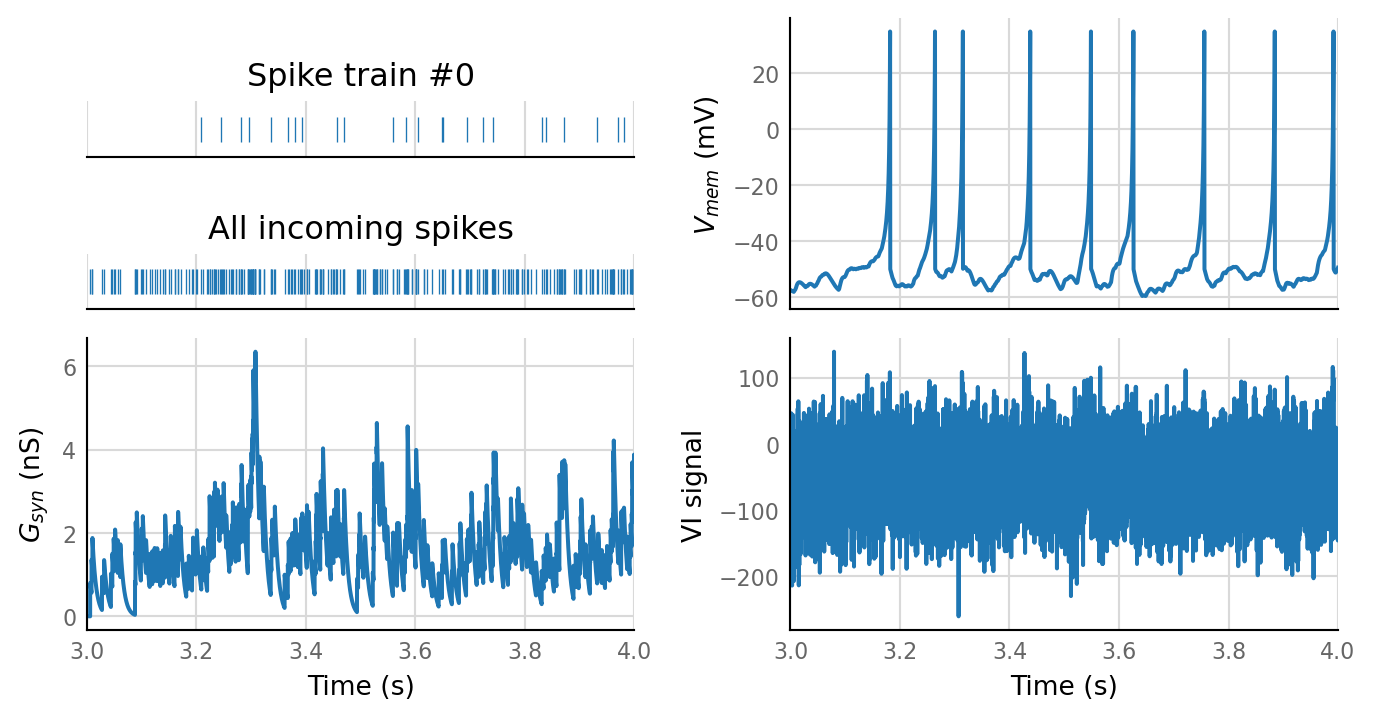

In [7]:
plot_sim_slice(sim_data, t_start=3 * second, duration=1 * second);

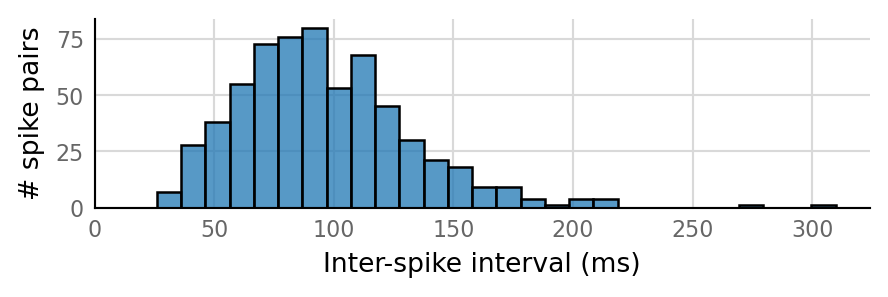

Output spike rate (1 / median ISI): 11 Hz


In [8]:
v.sim.izhikevich_neuron.show_output_spike_stats(sim_data.izh_output);

In [9]:
test_data, test_summaries = v.N_to_1_experiment.test_connections(sim_data);

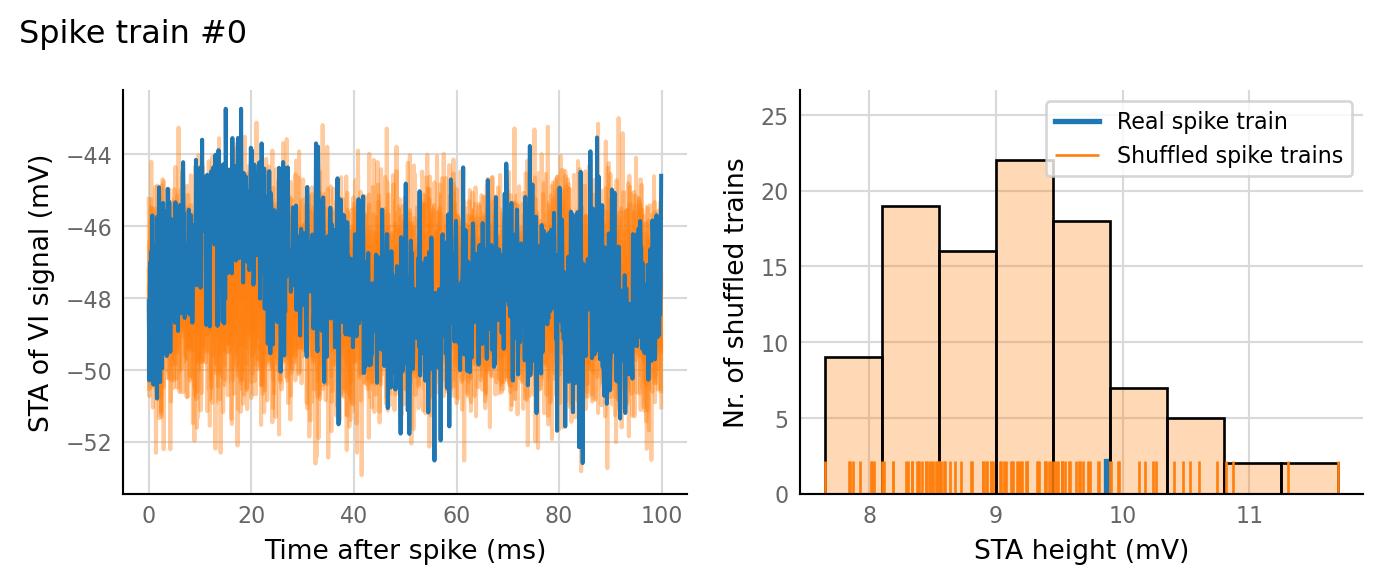

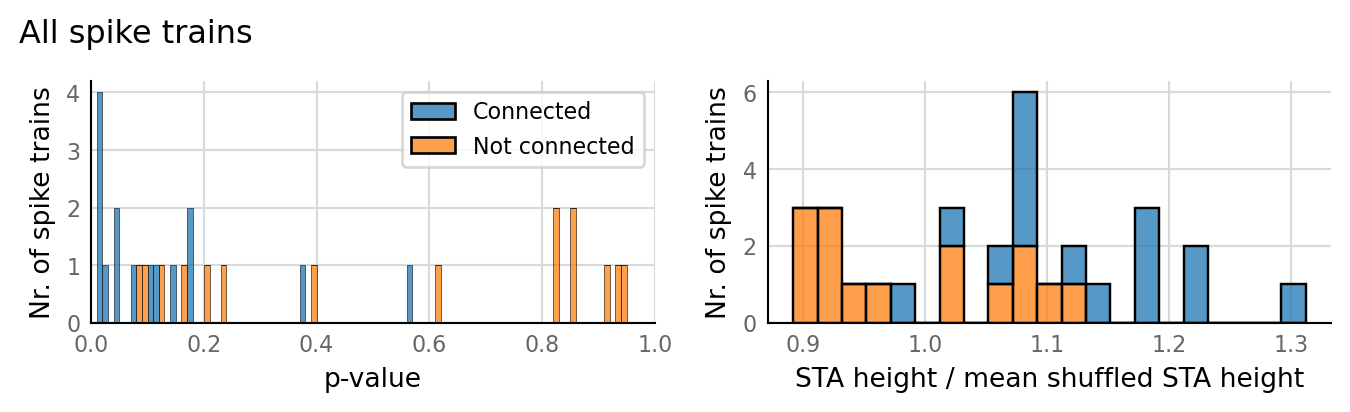

In [10]:
v.N_to_1_experiment.plot_conntest(test_data, test_summaries, sim_data)

In [11]:
classifs = v.conntest.classification.sweep_threshold(test_summaries, sim_data.is_connected);

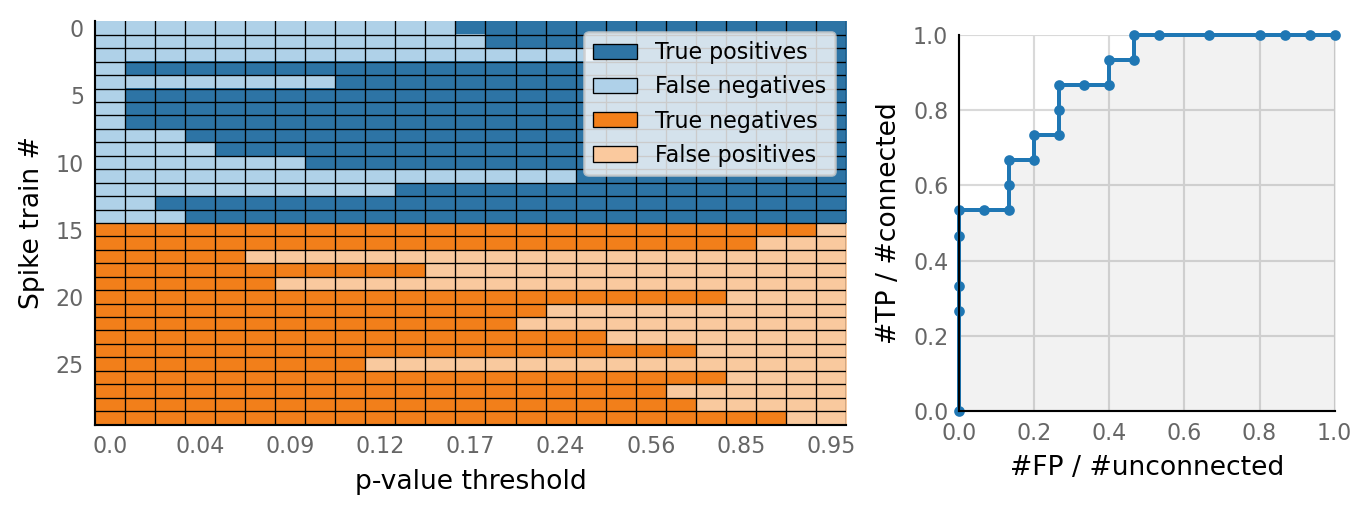

In [12]:
v.N_to_1_experiment.plot_classifications_with_ROC(classifs)

## Vary SNR

(SNR = voltage imaging signal-to-noise ratio).

Reminder: recording duration is 1 minute, and median reported VI SNR from the literature is 10.

In [13]:
test_connections = v.N_to_1_experiment.test_connections 
sweep_threshold = v.conntest.classification.sweep_threshold

def sim_and_eval(params):
    with v.time_op("Sim", end=" | "):
        sim_data = simulate(params)
    with v.time_op("Conntest"):
        test_data, test_summaries = test_connections(sim_data, inline_meter=True)
    classifs = sweep_threshold(test_summaries, sim_data.is_connected)
    return classifs

In [14]:
SNRs = [1, 2, 4, 8];

In [15]:
from copy import deepcopy

In [16]:
%%time

thr_sweeps = []

for SNR in SNRs:
    v.bprint(f"SNR: {SNR}", end=" | ")
    params = deepcopy(base_params)
    params.imaging_spike_SNR = SNR
    thr_sweep = sim_and_eval(params)
    thr_sweeps.append(thr_sweep)

SNR: 1 | Sim: [0.021 s] | Conntest: [0.41 s]
SNR: 2 | Sim: [0.019 s] | Conntest: [0.51 s]
SNR: 4 | Sim: [0.02 s] | Conntest: [0.41 s]
SNR: 8 | Sim: [0.021 s] | Conntest: [0.41 s]
Wall time: 1.88 s


Note: these timings are not real execution time. The results are namely cached, so this is actually time spent finding and reading precomputed results from disk. 

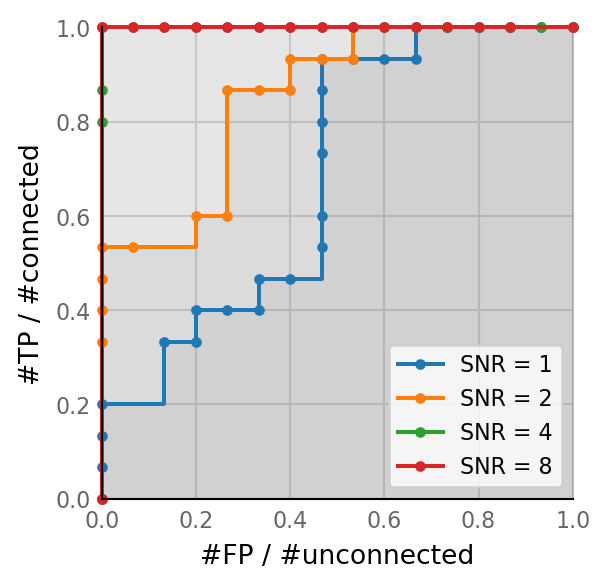

In [17]:
plot_ROC = v.conntest.classification.plot_ROC

ax = None
for i, (SNR, classifs) in enumerate(zip(SNRs, thr_sweeps)):
    ax = plot_ROC(classifs, ax,
                  label=f"SNR = {SNR}",
                  marker='.',
                  color=f"C{i}")
ax.legend();

In [18]:
def AUC(thr_sweep):
    TPRs = [tr.evaluation.TPR for tr in thr_sweep]
    FPRs = [tr.evaluation.FPR for tr in thr_sweep]
    AUC = 0
    # this is not the same as `np.trapz` e.g.
    for i in range(len(FPRs) - 1):
        AUC += (FPRs[i+1] - FPRs[i]) * TPRs[i]
    return AUC

In [19]:
df = pd.DataFrame(dict(SNR=SNRs, AUC=[AUC(s) for s in thr_sweeps]))

,SNR,AUC
0,1,0.684444
1,2,0.853333
2,4,1.000000
3,8,1.000000


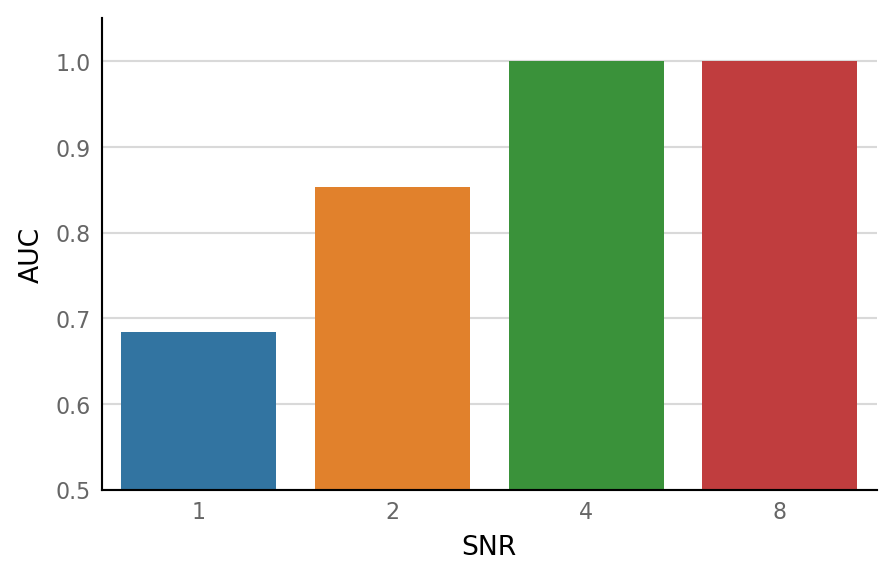

In [20]:
ax = sns.barplot(data=df, x="SNR", y="AUC")
ax.set_ylim(bottom=0.5);

## Vary recording duration

Reminder: SNR here is 2, and VI photobleaching has time constant of ~10 minutes.

In [21]:
durations = (
    30 * second,
    1 * minute,
    2 * minute,
    4 * minute,
);

In [35]:
def format_duration(T):
    T_min = T / minute
    return f"{T_min:.2G} minute{'' if T_min == 1 else 's'}"

In [36]:
rec_param_label = "Recording duration"
rec_value_labels = [format_duration(T) for T in durations];

In [37]:
from dataclasses import replace

def vary_param(param, values, param_label, value_labels):
    max_label_len = max([len(label) for label in value_labels])
    thr_sweeps = []
    for val, val_label in zip(values, value_labels):
        v.bprint(f"{param_label}: {val_label:<{max_label_len}}", end=" | ")
        params = replace(base_params, **{param: val})
        thr_sweep = sim_and_eval(params)
        thr_sweeps.append(thr_sweep)
    return thr_sweeps

%time rec_sweeps = vary_param("sim_duration", durations, rec_param_label, rec_value_labels)

Recording duration: 0.5 minutes | Sim: [0.012 s] | Conntest: [0.57 s]
Recording duration: 1 minute    | Sim: [0.02 s] | Conntest: [0.44 s]
Recording duration: 2 minutes   | Sim: [0.041 s] | Conntest: [0.48 s]
Recording duration: 4 minutes   | Sim: [0.073 s] | Conntest: [0.57 s]
Wall time: 2.28 s


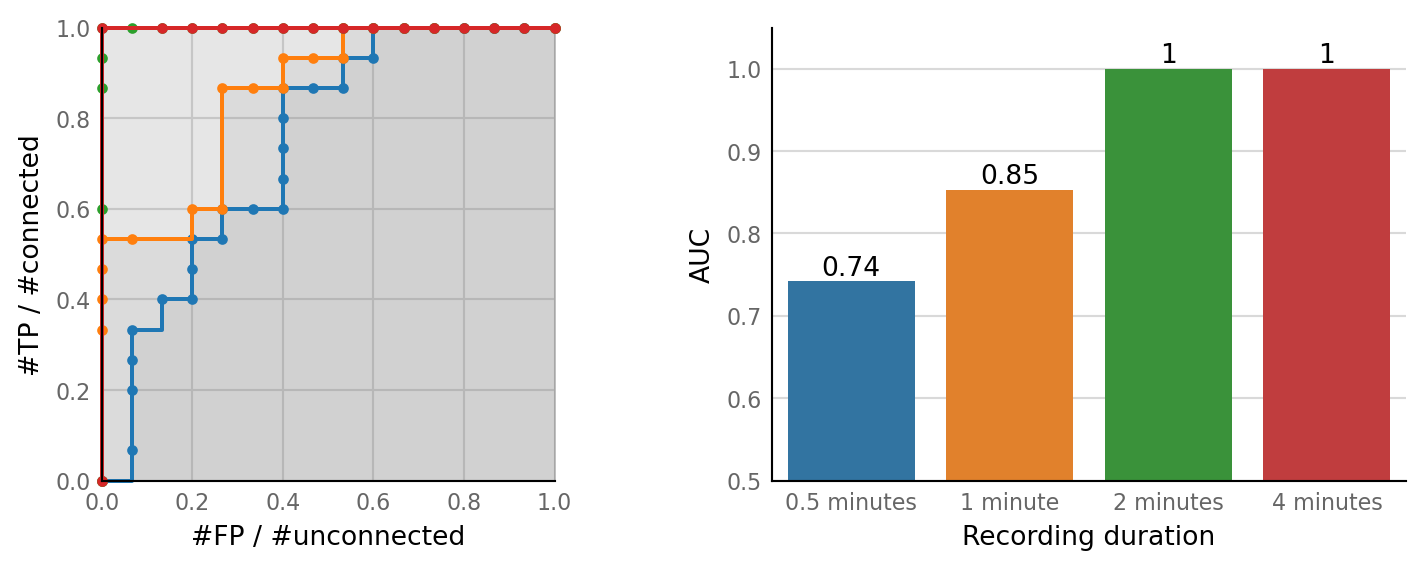

In [38]:
plot_ROC = v.conntest.classification.plot_ROC

def plot_sweeps(thr_sweeps, param_label, value_labels):
    
    _, (left_ax, right_ax) = plt.subplots(ncols=2, **v.figsize(aspect=3, width=900))
    
    # ROC
    for i, (sweep, label) in enumerate(zip(thr_sweeps, value_labels)):
        plot_ROC(sweep,
                 left_ax,
                 label=label,
                 marker='.',
                 color=f"C{i}")
    
    # AUC barplot
    AUCs = [AUC(s) for s in thr_sweeps]
    df = pd.DataFrame({param_label: value_labels, "AUC": AUCs})
    sns.barplot(data=df, x=param_label, y="AUC", ax=right_ax)
    for x, y in zip(right_ax.get_xticks(), AUCs):
        right_ax.text(x, y, format(y, ".2G"), va='bottom', ha='center')
    right_ax.set_ylim(bottom=0.5);
    
    return left_ax, right_ax


left_ax, right_ax = plot_sweeps(rec_sweeps, rec_param_label, rec_value_labels);

## Reproducibility

In [30]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Thu 21 Jan** 2021, at 13:49 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/458dcc5e21c4d3b7f9c7070c29d4e84b766ac785
) (Thu 21 Jan 2021, 01:20).

No uncommitted changes.

Platform:

Windows-10
CPython 3.8.6 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.5
matplotlib           3.3.3
numba                0.52.0
seaborn              0.11.1
scipy                1.6.0
scikit-learn         0.24.0
preload              2.2
nptyping             1.4.0
tqdm                 4.56.0


Full conda list:

```
# packages in environment at C:\conda:
#
# Name                    Version                   Build  Channel
anyio                     2.0.2            py38haa244fe_4    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py38h294d835_2    conda-forge
async_generator           1.10                       py_0    conda-forge
atomicwrites              1.4.0              pyh9f0ad1d_0    conda-forge
attrs                     20.3.0             pyhd3deb0d_0    conda-forge
babel                     2.9.0              pyhd3deb0d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.1                      py_0    conda-forge
black                     20.8b1                     py_1    conda-forge
bleach                    3.2.1              pyh9f0ad1d_0    conda-forge
bokeh                     2.2.3            py38haa244fe_0    conda-forge
brotlipy                  0.7.0           py38h294d835_1001    conda-forge
bzip2                     1.0.8                h8ffe710_4    conda-forge
ca-certificates           2020.12.5            h5b45459_0    conda-forge
certifi                   2020.12.5        py38haa244fe_1    conda-forge
cffi                      1.14.4           py38hd8c33c5_1    conda-forge
chardet                   4.0.0            py38haa244fe_1    conda-forge
click                     7.1.2              pyh9f0ad1d_0    conda-forge
cloudpickle               1.6.0                      py_0    conda-forge
colorama                  0.4.4              pyh9f0ad1d_0    conda-forge
conda                     4.9.2            py38haa244fe_0    conda-forge
conda-package-handling    1.7.2            py38h8934438_0    conda-forge
console_shortcut          0.1.1                         4  
cryptography              3.3.1            py38hd8c33c5_1    conda-forge
cycler                    0.10.0                     py_2    conda-forge
cytoolz                   0.11.0           py38h294d835_1    conda-forge
dask                      2021.1.0           pyhd8ed1ab_0    conda-forge
dask-core                 2021.1.0           pyhd8ed1ab_0    conda-forge
dataclasses               0.7                pyhb2cacf7_7    conda-forge
decorator                 4.4.2                      py_0    conda-forge
defusedxml                0.6.0                      py_0    conda-forge
distributed               2021.1.0         py38haa244fe_1    conda-forge
docutils                  0.16                     pypi_0    pypi
entrypoints               0.3             pyhd8ed1ab_1003    conda-forge
freetype                  2.10.4               h546665d_0    conda-forge
fsspec                    0.8.5              pyhd8ed1ab_0    conda-forge
heapdict                  1.0.1                      py_0    conda-forge
icu                       68.1                 h0e60522_0    conda-forge
idna                      2.10               pyh9f0ad1d_0    conda-forge
importlib-metadata        3.4.0            py38haa244fe_0    conda-forge
importlib_metadata        3.4.0                hd8ed1ab_0    conda-forge
iniconfig                 1.1.1              pyh9f0ad1d_0    conda-forge
intel-openmp              2020.3             h57928b3_311    conda-forge
ipykernel                 5.4.2            py38h7b7c402_0    conda-forge
ipython                   7.19.0           py38hc5df569_0    conda-forge
ipython_genutils          0.2.0                      py_1    conda-forge
ipywidgets                7.6.3              pyhd3deb0d_0    conda-forge
jedi                      0.17.2           py38haa244fe_1    conda-forge
jinja2                    2.11.2             pyh9f0ad1d_0    conda-forge
joblib                    1.0.0              pyhd8ed1ab_0    conda-forge
jpeg                      9d                   h8ffe710_0    conda-forge
json5                     0.9.5              pyh9f0ad1d_0    conda-forge
jsonschema                3.2.0                      py_2    conda-forge
jupyter_client            6.1.11             pyhd8ed1ab_1    conda-forge
jupyter_contrib_core      0.3.3                      py_2    conda-forge
jupyter_contrib_nbextensions 0.5.1            py38h32f6830_1    conda-forge
jupyter_core              4.7.0            py38haa244fe_0    conda-forge
jupyter_highlight_selected_word 0.2.0           py38h32f6830_1002    conda-forge
jupyter_latex_envs        1.4.6           py38h32f6830_1001    conda-forge
jupyter_nbextensions_configurator 0.4.1            py38h32f6830_2    conda-forge
jupyter_server            1.2.2            py38haa244fe_1    conda-forge
jupyterlab                3.0.5              pyhd8ed1ab_0    conda-forge
jupyterlab-classic        0.1.3              pyhd8ed1ab_0    conda-forge
jupyterlab_pygments       0.1.2              pyh9f0ad1d_0    conda-forge
jupyterlab_server         2.1.2              pyhd8ed1ab_0    conda-forge
jupyterlab_widgets        1.0.0              pyhd8ed1ab_1    conda-forge
jupytray                  0.7.post10+dirty           dev_0    <develop>
keyring                   21.8.0                   pypi_0    pypi
kiwisolver                1.3.1            py38hbd9d945_1    conda-forge
krb5                      1.17.2               hbae68bd_0    conda-forge
libarchive                3.5.1                hf621db8_1    conda-forge
libblas                   3.9.0                     7_mkl    conda-forge
libcblas                  3.9.0                     7_mkl    conda-forge
libclang                  11.0.1          default_h5c34c98_0    conda-forge
libcurl                   7.71.1               h4b64cdc_8    conda-forge
libiconv                  1.16                 he774522_0    conda-forge
liblapack                 3.9.0                     7_mkl    conda-forge
libpng                    1.6.37               h1d00b33_2    conda-forge
libsodium                 1.0.18               h8d14728_1    conda-forge
libsolv                   0.7.16               h200bbdf_0    conda-forge
libssh2                   1.9.0                hb06d900_5    conda-forge
libtiff                   4.2.0                hc10be44_0    conda-forge
libxml2                   2.9.10               hf5bbc77_3    conda-forge
libxslt                   1.1.33               h65864e5_2    conda-forge
llvmlite                  0.35.0           py38h57a6900_1    conda-forge
locket                    0.2.0                      py_2    conda-forge
lxml                      4.6.2            py38h292cb97_1    conda-forge
lz4-c                     1.9.3                h8ffe710_0    conda-forge
lzo                       2.10              he774522_1000    conda-forge
m2w64-gcc-libgfortran     5.3.0                         6    conda-forge
m2w64-gcc-libs            5.3.0                         7    conda-forge
m2w64-gcc-libs-core       5.3.0                         7    conda-forge
m2w64-gmp                 6.1.0                         2    conda-forge
m2w64-libwinpthread-git   5.0.0.4634.697f757               2    conda-forge
mamba                     0.7.8            py38hdd88130_0    conda-forge
markupsafe                1.1.1            py38h294d835_3    conda-forge
matplotlib-base           3.3.3            py38h34ddff4_0    conda-forge
menuinst                  1.4.16           py38he774522_1  
mistune                   0.8.4           py38h294d835_1003    conda-forge
mkl                       2020.4             hb70f87d_311    conda-forge
more-itertools            8.6.0              pyhd8ed1ab_0    conda-forge
mpmath                    1.1.0                      py_0    conda-forge
msgpack-python            1.0.2            py38hbd9d945_1    conda-forge
msys2-conda-epoch         20160418                      1    conda-forge
mypy_extensions           0.4.3            py38haa244fe_3    conda-forge
nb_conda_kernels          2.3.1            py38haa244fe_0    conda-forge
nbclassic                 0.2.6              pyhd8ed1ab_0    conda-forge
nbclient                  0.5.1                      py_0    conda-forge
nbconvert                 6.0.7            py38haa244fe_3    conda-forge
nbformat                  5.0.8                      py_0    conda-forge
nest-asyncio              1.4.3              pyhd8ed1ab_0    conda-forge
notebook                  6.2.0            py38haa244fe_0    conda-forge
nptyping                  1.4.0                    pypi_0    pypi
numba                     0.52.0           py38h4c96930_0    conda-forge
numpy                     1.19.5           py38h0cc643e_1    conda-forge
olefile                   0.46               pyh9f0ad1d_1    conda-forge
openssl                   1.1.1i               h8ffe710_0    conda-forge
packaging                 20.8               pyhd3deb0d_0    conda-forge
pandas                    1.2.0            py38h4c96930_1    conda-forge
pandoc                    2.11.3.2             h8ffe710_0    conda-forge
pandocfilters             1.4.2                      py_1    conda-forge
parso                     0.7.1              pyh9f0ad1d_0    conda-forge
partd                     1.1.0                      py_0    conda-forge
pathspec                  0.8.1              pyhd3deb0d_0    conda-forge
patsy                     0.5.1                      py_0    conda-forge
pickleshare               0.7.5                   py_1003    conda-forge
pillow                    8.1.0            py38hf7ce48b_1    conda-forge
pip                       20.3.3             pyhd8ed1ab_0    conda-forge
pkginfo                   1.6.1                    pypi_0    pypi
pluggy                    0.13.1           py38haa244fe_4    conda-forge
powershell_shortcut       0.0.1                         3  
preload                   2.2                      pypi_0    pypi
prometheus_client         0.9.0              pyhd3deb0d_0    conda-forge
prompt-toolkit            3.0.10             pyha770c72_0    conda-forge
psutil                    5.8.0            py38h294d835_1    conda-forge
puprelease                1.6.1                     dev_0    <develop>
py                        1.10.0             pyhd3deb0d_0    conda-forge
py-cpuinfo                7.0.0                    pypi_0    pypi
pycosat                   0.6.3           py38h294d835_1006    conda-forge
pycparser                 2.20               pyh9f0ad1d_2    conda-forge
pygments                  2.7.3              pyhd8ed1ab_0    conda-forge
pyopenssl                 20.0.1             pyhd8ed1ab_0    conda-forge
pyparsing                 2.4.7              pyh9f0ad1d_0    conda-forge
pyqt                      5.12.3           py38haa244fe_7    conda-forge
pyqt-impl                 5.12.3           py38h885f38d_7    conda-forge
pyqt5-sip                 4.19.18          py38h885f38d_7    conda-forge
pyqtchart                 5.12             py38h885f38d_7    conda-forge
pyqtwebengine             5.12.1           py38h885f38d_7    conda-forge
pyrsistent                0.17.3           py38h294d835_2    conda-forge
pysocks                   1.7.1            py38haa244fe_3    conda-forge
pytest                    6.2.1            py38haa244fe_1    conda-forge
python                    3.8.6           h7840368_4_cpython    conda-forge
python-dateutil           2.8.1                      py_0    conda-forge
python_abi                3.8                      1_cp38    conda-forge
pytz                      2020.5             pyhd8ed1ab_0    conda-forge
pywin32                   228              py38h294d835_1    conda-forge
pywin32-ctypes            0.2.0                    pypi_0    pypi
pywinpty                  0.5.7            py38h32f6830_1    conda-forge
pyyaml                    5.3.1            py38h294d835_2    conda-forge
pyzmq                     20.0.0           py38h7a0e47e_1    conda-forge
qt                        5.12.9               h5909a2a_3    conda-forge
readme-renderer           28.0                     pypi_0    pypi
regex                     2020.11.13       py38h294d835_1    conda-forge
reproc                    14.2.1               h8ffe710_0    conda-forge
reproc-cpp                14.2.1               h0e60522_0    conda-forge
requests                  2.25.1             pyhd3deb0d_0    conda-forge
requests-toolbelt         0.9.1                    pypi_0    pypi
rfc3986                   1.4.0                    pypi_0    pypi
ruamel_yaml               0.15.80         py38h294d835_1003    conda-forge
scikit-learn              0.24.0           py38ha09990b_0    conda-forge
scipy                     1.6.0            py38h5f893b4_0    conda-forge
seaborn                   0.11.1               h57928b3_0    conda-forge
seaborn-base              0.11.1             pyhd8ed1ab_0    conda-forge
send2trash                1.5.0                      py_0    conda-forge
setuptools                49.6.0           py38haa244fe_3    conda-forge
setuptools-scm            5.0.1                    pypi_0    pypi
six                       1.15.0             pyh9f0ad1d_0    conda-forge
snakeviz                  2.1.0              pyh9f0ad1d_0    conda-forge
sniffio                   1.2.0            py38haa244fe_1    conda-forge
sortedcontainers          2.3.0              pyhd8ed1ab_0    conda-forge
sqlite                    3.34.0               h8ffe710_0    conda-forge
statsmodels               0.12.1           py38h347fdf6_2    conda-forge
sympy                     1.7.1            py38haa244fe_1    conda-forge
tblib                     1.6.0                      py_0    conda-forge
terminado                 0.9.2            py38haa244fe_0    conda-forge
testpath                  0.4.4                      py_0    conda-forge
threadpoolctl             2.1.0              pyh5ca1d4c_0    conda-forge
tk                        8.6.10               h8ffe710_1    conda-forge
toml                      0.10.2             pyhd8ed1ab_0    conda-forge
toolz                     0.11.1                     py_0    conda-forge
tornado                   6.1              py38h294d835_1    conda-forge
tqdm                      4.56.0             pyhd8ed1ab_0    conda-forge
traitlets                 5.0.5                      py_0    conda-forge
twine                     3.3.0                    pypi_0    pypi
typed-ast                 1.4.2            py38h294d835_0    conda-forge
typing_extensions         3.7.4.3                    py_0    conda-forge
typish                    1.9.1                    pypi_0    pypi
urllib3                   1.26.2             pyhd8ed1ab_0    conda-forge
vc                        14.2                 hb210afc_2    conda-forge
voltage-to-wiring-sim     0.1                       dev_0    <develop>
vs2015_runtime            14.28.29325          h5e1d092_0    conda-forge
wcwidth                   0.2.5              pyh9f0ad1d_2    conda-forge
webencodings              0.5.1                      py_1    conda-forge
wheel                     0.36.2             pyhd3deb0d_0    conda-forge
widgetsnbextension        3.5.1            py38haa244fe_4    conda-forge
win_inet_pton             1.1.0            py38haa244fe_2    conda-forge
wincertstore              0.2             py38haa244fe_1006    conda-forge
windows-curses            2.2.0                    pypi_0    pypi
winpty                    0.4.3                         4    conda-forge
winshell                  0.6                      pypi_0    pypi
xz                        5.2.5                h62dcd97_1    conda-forge
yaml                      0.2.5                he774522_0    conda-forge
zeromq                    4.3.3                h0e60522_3    conda-forge
zict                      2.0.0                      py_0    conda-forge
zipp                      3.4.0                      py_0    conda-forge
zlib                      1.2.11            h62dcd97_1010    conda-forge
zstd                      1.4.8                h4e2f164_1    conda-forge
```